# Pitch and roll angles from a MPU6050 sensor and CF filter
###Diego Chavez - diegochav3z
###New Mexico State University
###email: saidcha@nmsu.edu - saidcharana@gmail.com 
###website: diegochav3z.com  
Jupyter notebook code to obtain pitch and roll angles using a MPU6050 intertial motion unit. The MPU6050 used for this code is a 6-DOF with 3 degrees dedicated to an accelerometer and the other 3 dedicated to a gyroscope. The output of the accelerometer is normalized to +/- 2 LSB/g, therefore its output is in (g). For the gyroscope its sensitivity 131LSB/degrees/second, therefore its output is in (degrees/s). The communication protocol used was I2C. 

All sensors come with noise this means that a filter is necessary to process the information and have clear data coming out of it. The forces actuating in the object is mainly provided by the accelerometer, however the accelerometer is very sensitive to small forces. This means that a 'low pass' filter needs to be used to counteract the disturbances. 
On the other hand the gyroscope provides the angular velocity, this one integrated gives a good measurement of the angular position. However due the nature of the integration, the data tends to drift away from the zero.

Here a complementary filter is implemented as follows:  
    >> The gyroscope values are integrated everytimestep to obtain an angle value. The accelerometer values are normalized vector values of the        gravitational force, this is why the atan2 function was used to obtain an angle value. 
    >> Gyroscope angle and accelerometer values are combined, where the accelerometer values complement the gyroscope values with a 0.02 to 0.98 distribution. So that the roll and pitch angles are given by: 
        >>> pitch/roll = Gyroscope_Angle*0.98 + Accelerometer_Angle*0.02
    
.
   


### Import Libraries 

In [36]:
from cmath import acos
import smbus			#import SMBus module of I2C
from time import sleep          #import
import numpy as np 
import math
import pickle
import matplotlib.pyplot as plt 
#Fonts
csfont = {'fontname':'Times New Roman'}
from adafruit_servokit import ServoKit
import time
import datetime 

Initialize the MPU6050 Registers and Addresses

In [37]:
PWR_MGMT_1   = 0x6B
SMPLRT_DIV   = 0x19
CONFIG       = 0x1A
GYRO_CONFIG  = 0x1B
INT_ENABLE   = 0x38
ACCEL_XOUT_H = 0x3B
ACCEL_YOUT_H = 0x3D
ACCEL_ZOUT_H = 0x3F
GYRO_XOUT_H  = 0x43
GYRO_YOUT_H  = 0x45
GYRO_ZOUT_H  = 0x47

In [38]:
def MPU_Init():
	#write to sample rate register
	bus.write_byte_data(Device_Address, SMPLRT_DIV, 7)
	
	#Write to power management register
	bus.write_byte_data(Device_Address, PWR_MGMT_1, 1)
	
	#Write to Configuration register
	bus.write_byte_data(Device_Address, CONFIG, 0)
	
	#Write to Gyro configuration register
	bus.write_byte_data(Device_Address, GYRO_CONFIG, 24)
	
	#Write to interrupt enable register
	bus.write_byte_data(Device_Address, INT_ENABLE, 1)

def read_raw_data(addr):
	#Accelero and Gyro value are 16-bit
        high = bus.read_byte_data(Device_Address, addr)
        low = bus.read_byte_data(Device_Address, addr+1)
    
        #concatenate higher and lower value
        value = ((high << 8) | low)
        
        #to get signed value from mpu6050
        if(value > 32768):
                value = value - 65536
        return value
def read_angles(Ax, Ay, Az): 
	Ar = np.zeros((1,3))
	Ad = np.zeros((1,3))
	Ar[0,2] = -1.0
	Ad[0,0] = Ax 
	Ad[0,1] = Ay 
	Ad[0,2] = Az
	A_mag = np.linalg.norm(Ad) #Normalization of Ad
	theta = math.degrees(math.atan((Ax/A_mag)/(Az/A_mag)))
	gamma = math.degrees(math.atan((Ay/A_mag)/(Az/A_mag)))
	ts = time.time()
	return ts, theta, gamma


bus = smbus.SMBus(1) 	# or bus = smbus.SMBus(0) for older version boards
Device_Address = 0x68   # Setup  device address


## Sensor Sampling Speed Frequency

In [39]:
#Sensor Initialization
MPU_Init()

In [40]:
SampleEndTime = time.time() + 10
SampleData = np.zeros((1,2))
i = 0
while time.time() <= SampleEndTime:
    i += 1
    StartTime = datetime.datetime.now()
    acc_x = read_raw_data(ACCEL_XOUT_H)
    acc_y = read_raw_data(ACCEL_YOUT_H)
    acc_z = read_raw_data(ACCEL_ZOUT_H)#Read Gyroscope raw value
    gyro_x = read_raw_data(GYRO_XOUT_H)
    gyro_y = read_raw_data(GYRO_YOUT_H)
    gyro_z = read_raw_data(GYRO_ZOUT_H)
    EndTime = datetime.datetime.now()
    time_diff = (EndTime - StartTime)
    execution_time = time_diff.total_seconds()
    temp = np.array([i, execution_time])
    SampleData = np.vstack((SampleData, temp))


### Plots

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


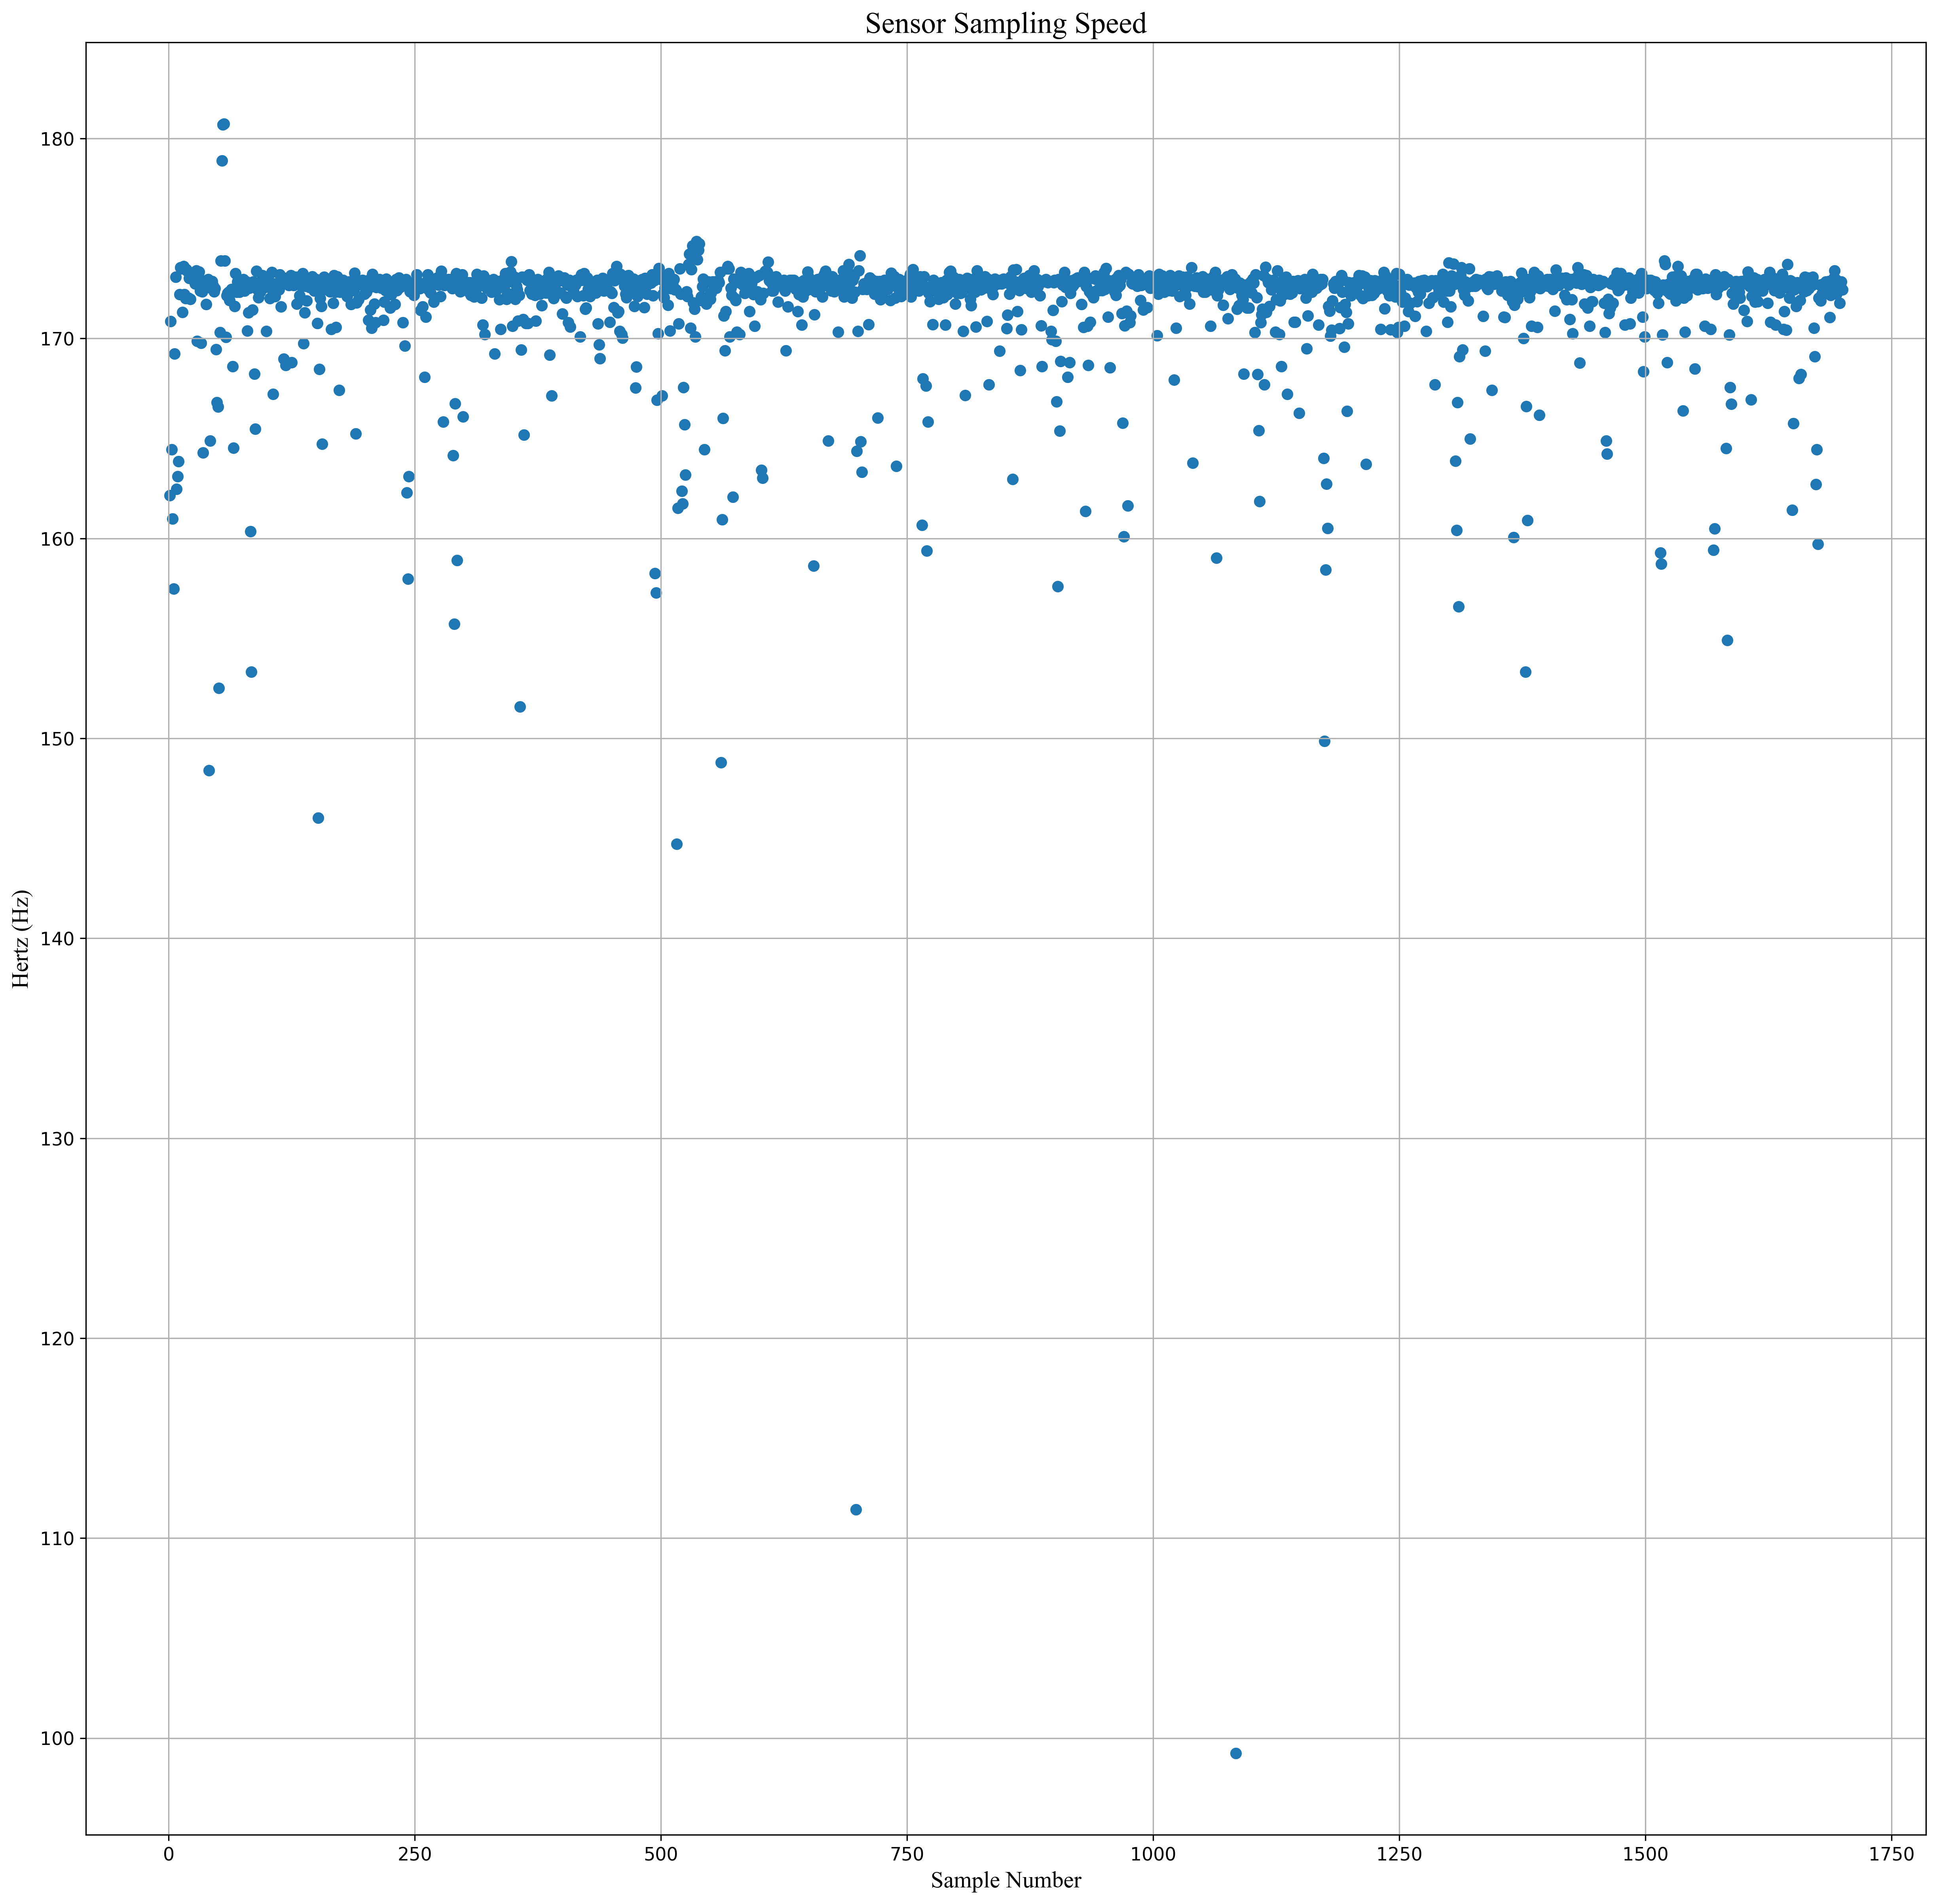

In [41]:
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 11})
plt.scatter(SampleData[:,0],1/SampleData[:,1])
#plt.yscale('log')
ax = plt.gca()
plt.xlabel('Sample Number', **csfont, fontsize = 14)
plt.ylabel('Hertz (Hz)', **csfont, fontsize = 14)
plt.title('Sensor Sampling Speed', **csfont, fontsize = 18)
plt.grid(True)
plt.savefig('Sample_Speed.png', dpi = 300)
plt.show()

## Angle measurement for t time

In [44]:
tTime = 20
sampleEndTime = time.time() + tTime
Data = np.zeros((1,13))
start_time = datetime.datetime.now()
#initial_values
Ax = 0 
Ay = 0 
Az = 0 
Gx = read_raw_data(ACCEL_XOUT_H)/16384.0
Gy = read_raw_data(ACCEL_YOUT_H)/16384.0
Gz = read_raw_data(ACCEL_ZOUT_H)/16384.0 
dt = 0.01 #Frequency is 10 ms or 0.01 s or 100 Hz
rollGyro = 0
pitchGyro = 0
while time.time() <= sampleEndTime:
    initialTime = time.time()
    finalTime = time.time() + 0.01
    while time.time() <= finalTime:
        acc_x = read_raw_data(ACCEL_XOUT_H)
        acc_y = read_raw_data(ACCEL_YOUT_H)
        acc_z = read_raw_data(ACCEL_ZOUT_H)
        gyro_x = read_raw_data(GYRO_XOUT_H)
        gyro_y = read_raw_data(GYRO_YOUT_H)
        gyro_z = read_raw_data(GYRO_ZOUT_H) #degres/s
        Ax = acc_x/16384.0 #m/s^2 
        Ay = acc_y/16384.0
        Az = acc_z/16384.0
        Gx = gyro_x/131.0
        Gy = gyro_y/131.0
        Gz = gyro_z/131.0
    t = time.time()
    #Pitch
    pitchGyro = pitchGyro + Gy*dt 
    rollGyro = rollGyro - Gx*dt
    
    
    pitchAcc =  math.atan2(Ax,math.sqrt(Ay**2+Az**2))*180/(math.pi)
    rollAcc = math.atan2(Ay, math.sqrt(Ax**2 + Az**2))*180/(math.pi)
    
    rawAcc_pitch = math.atan2(Ax,math.sqrt(Ay**2+Az**2))*180/(math.pi)
    rawAcc_roll = math.atan2(Ay, math.sqrt(Ax**2+Az**2))*180/(math.pi)
    
    rawGyro_pitch = Gy
    rawGyro_roll = Gx
    
    pitch = (pitchGyro*0.98) + 0.02*pitchAcc
    roll = rollGyro*0.98 + 0.02*rollAcc
    
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    execution_time = time_diff.total_seconds() * 1000
    
    
    temp = np.array([round(execution_time), Ax, Ay, Az, Gx, Gy, Gz, roll, pitch, rawAcc_roll, rawAcc_pitch, rawGyro_roll, rawGyro_pitch])
    Data = np.vstack([Data, temp])
    rollGyro = roll 
    pitchGyro = pitch 


### Plot of angle measurements

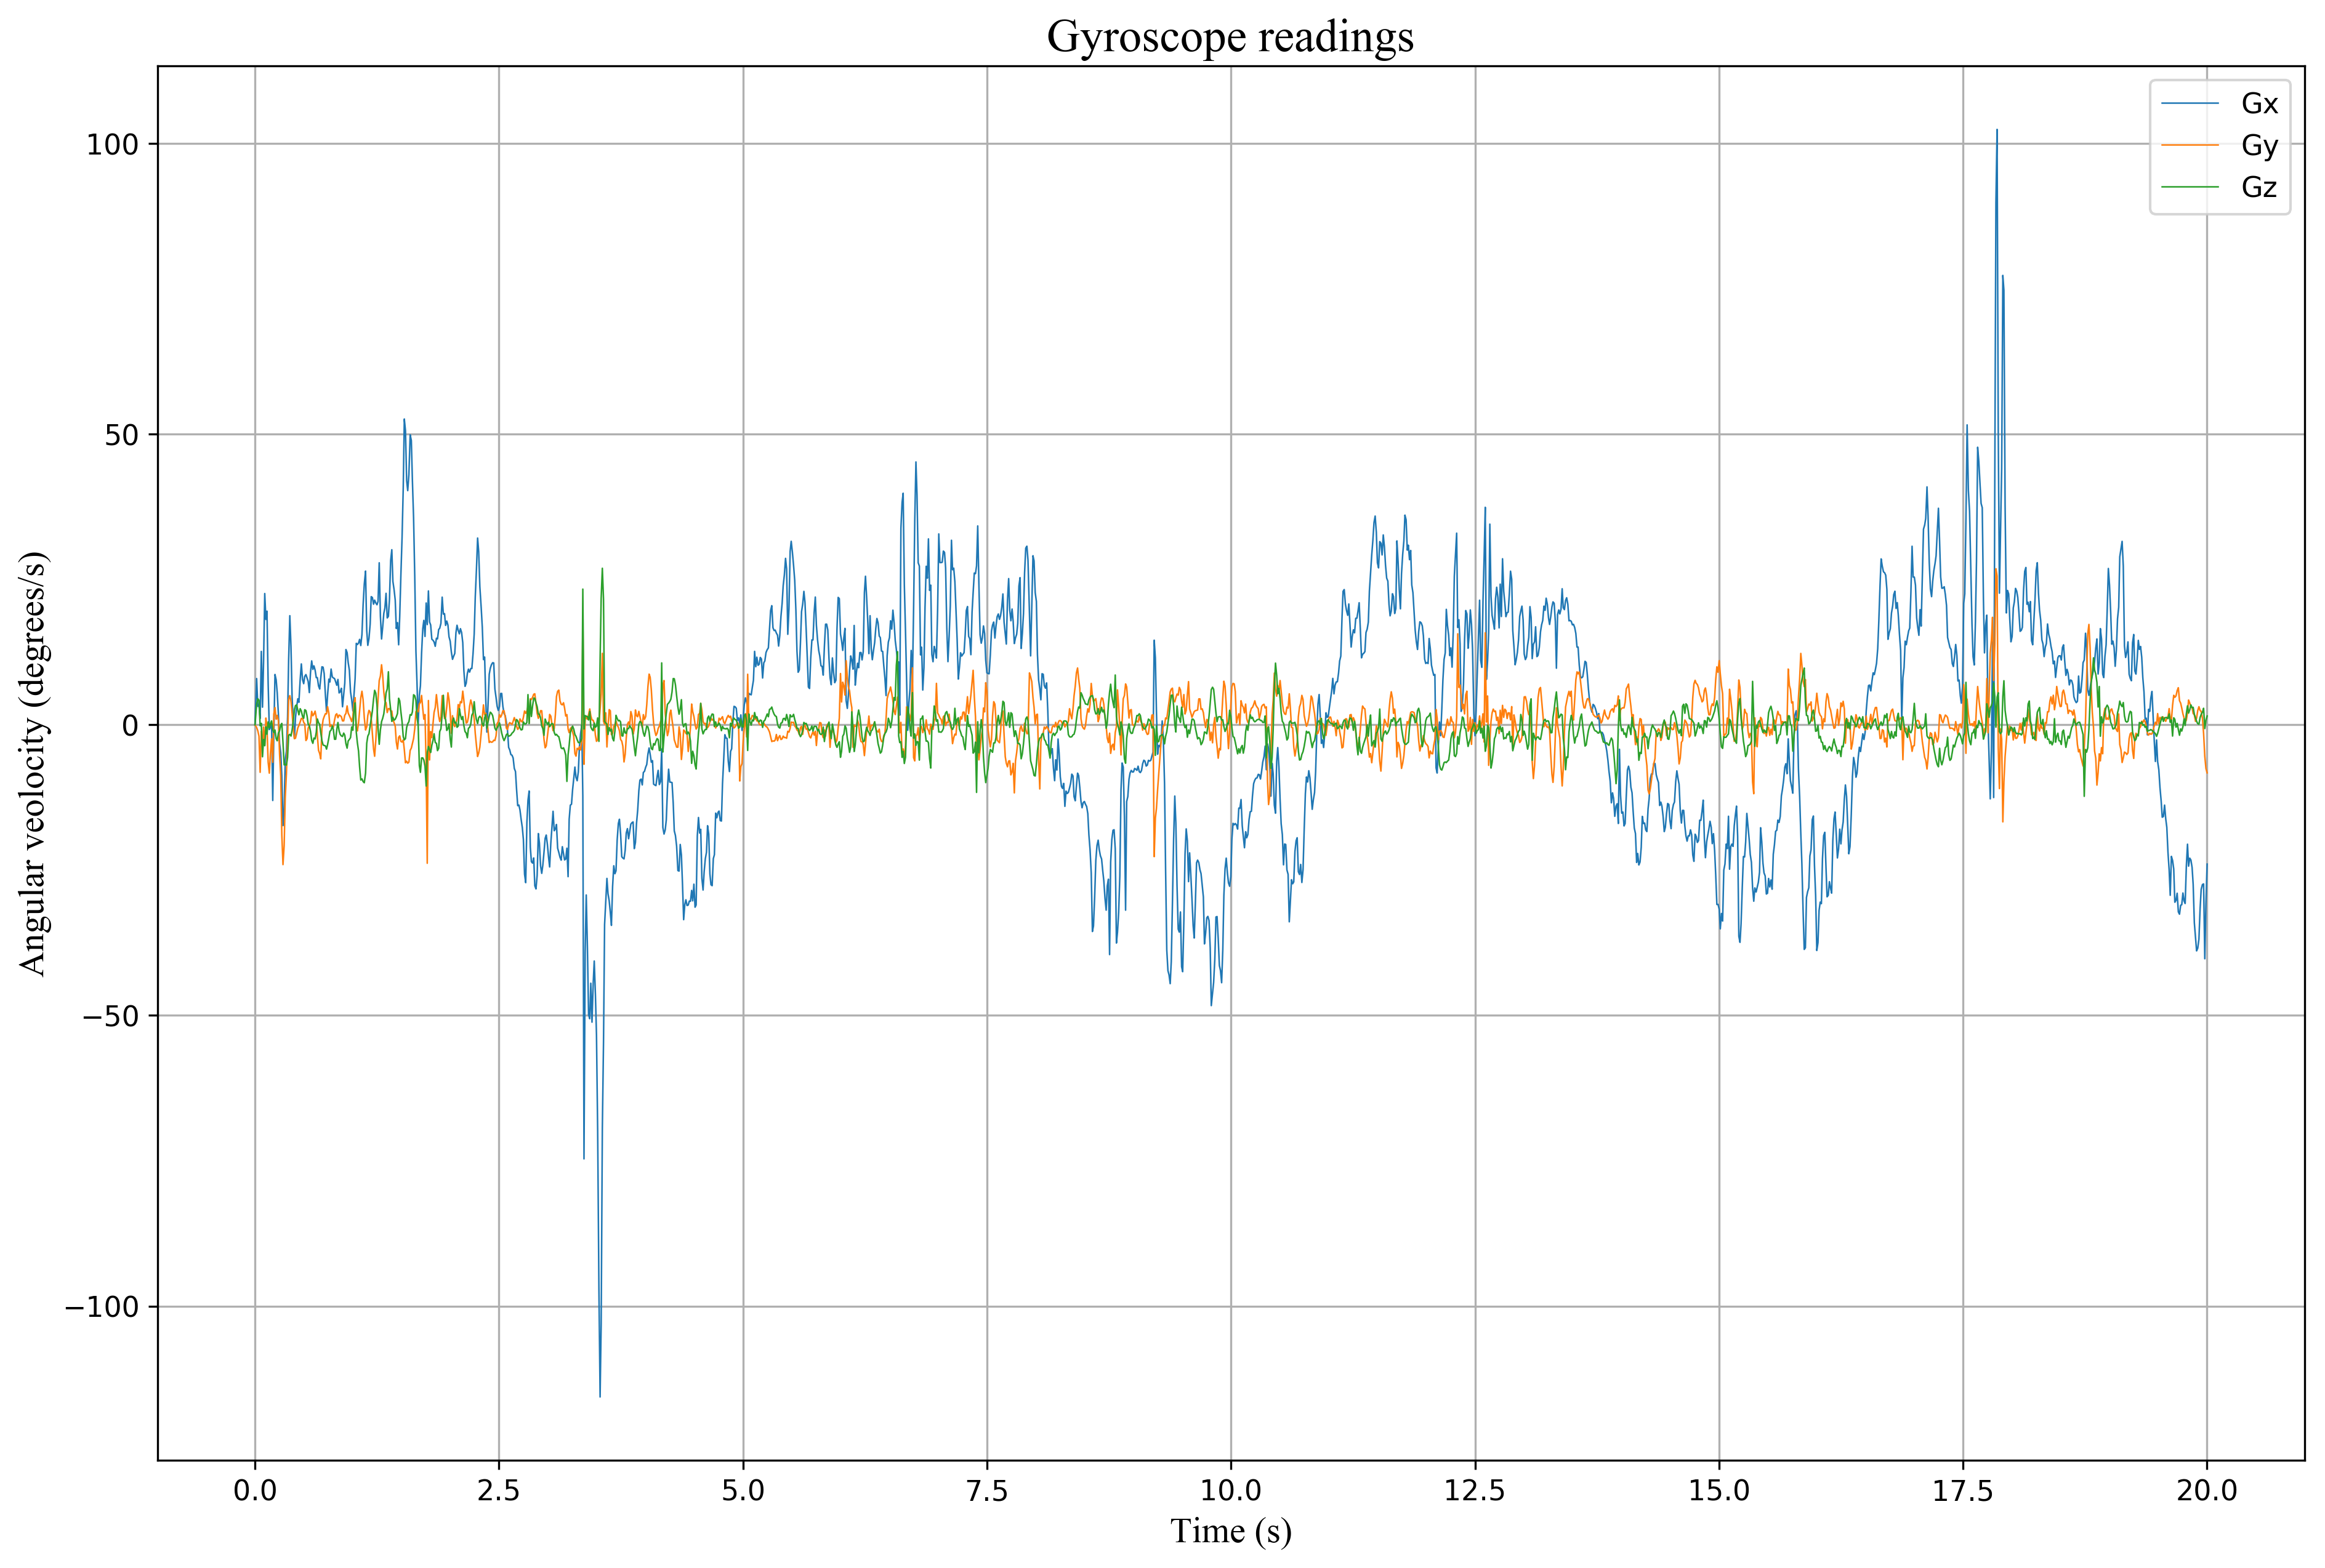

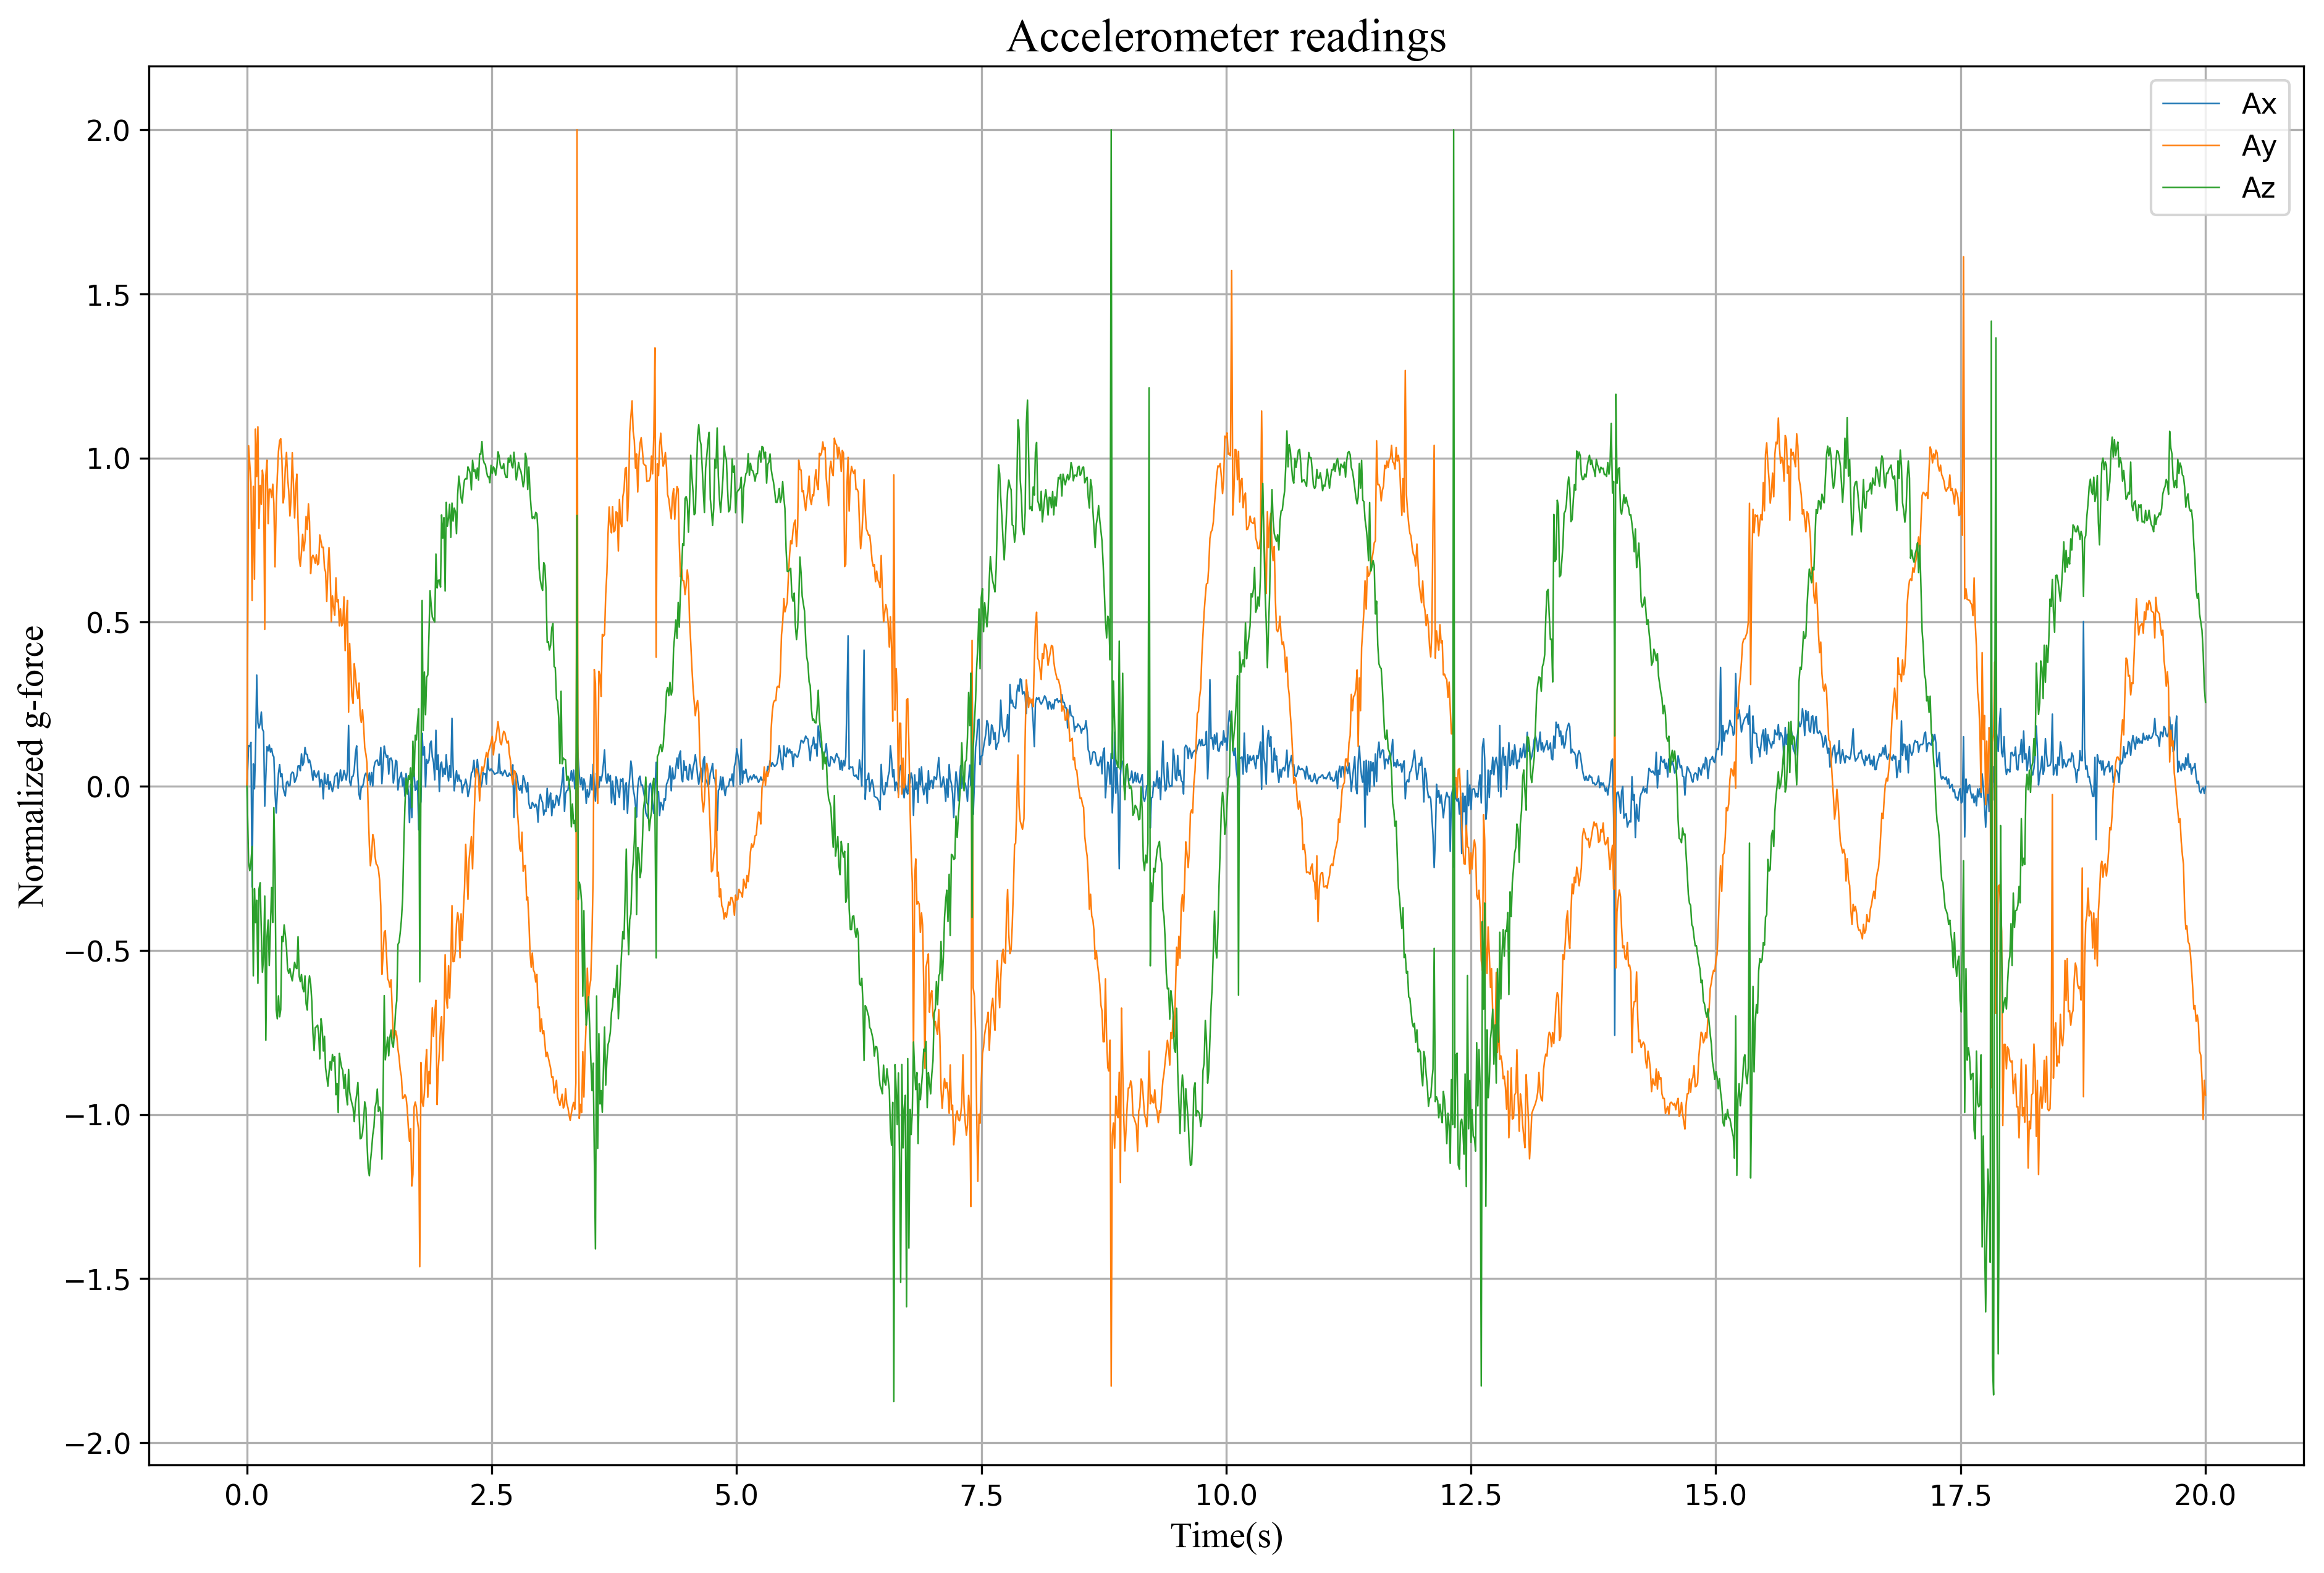

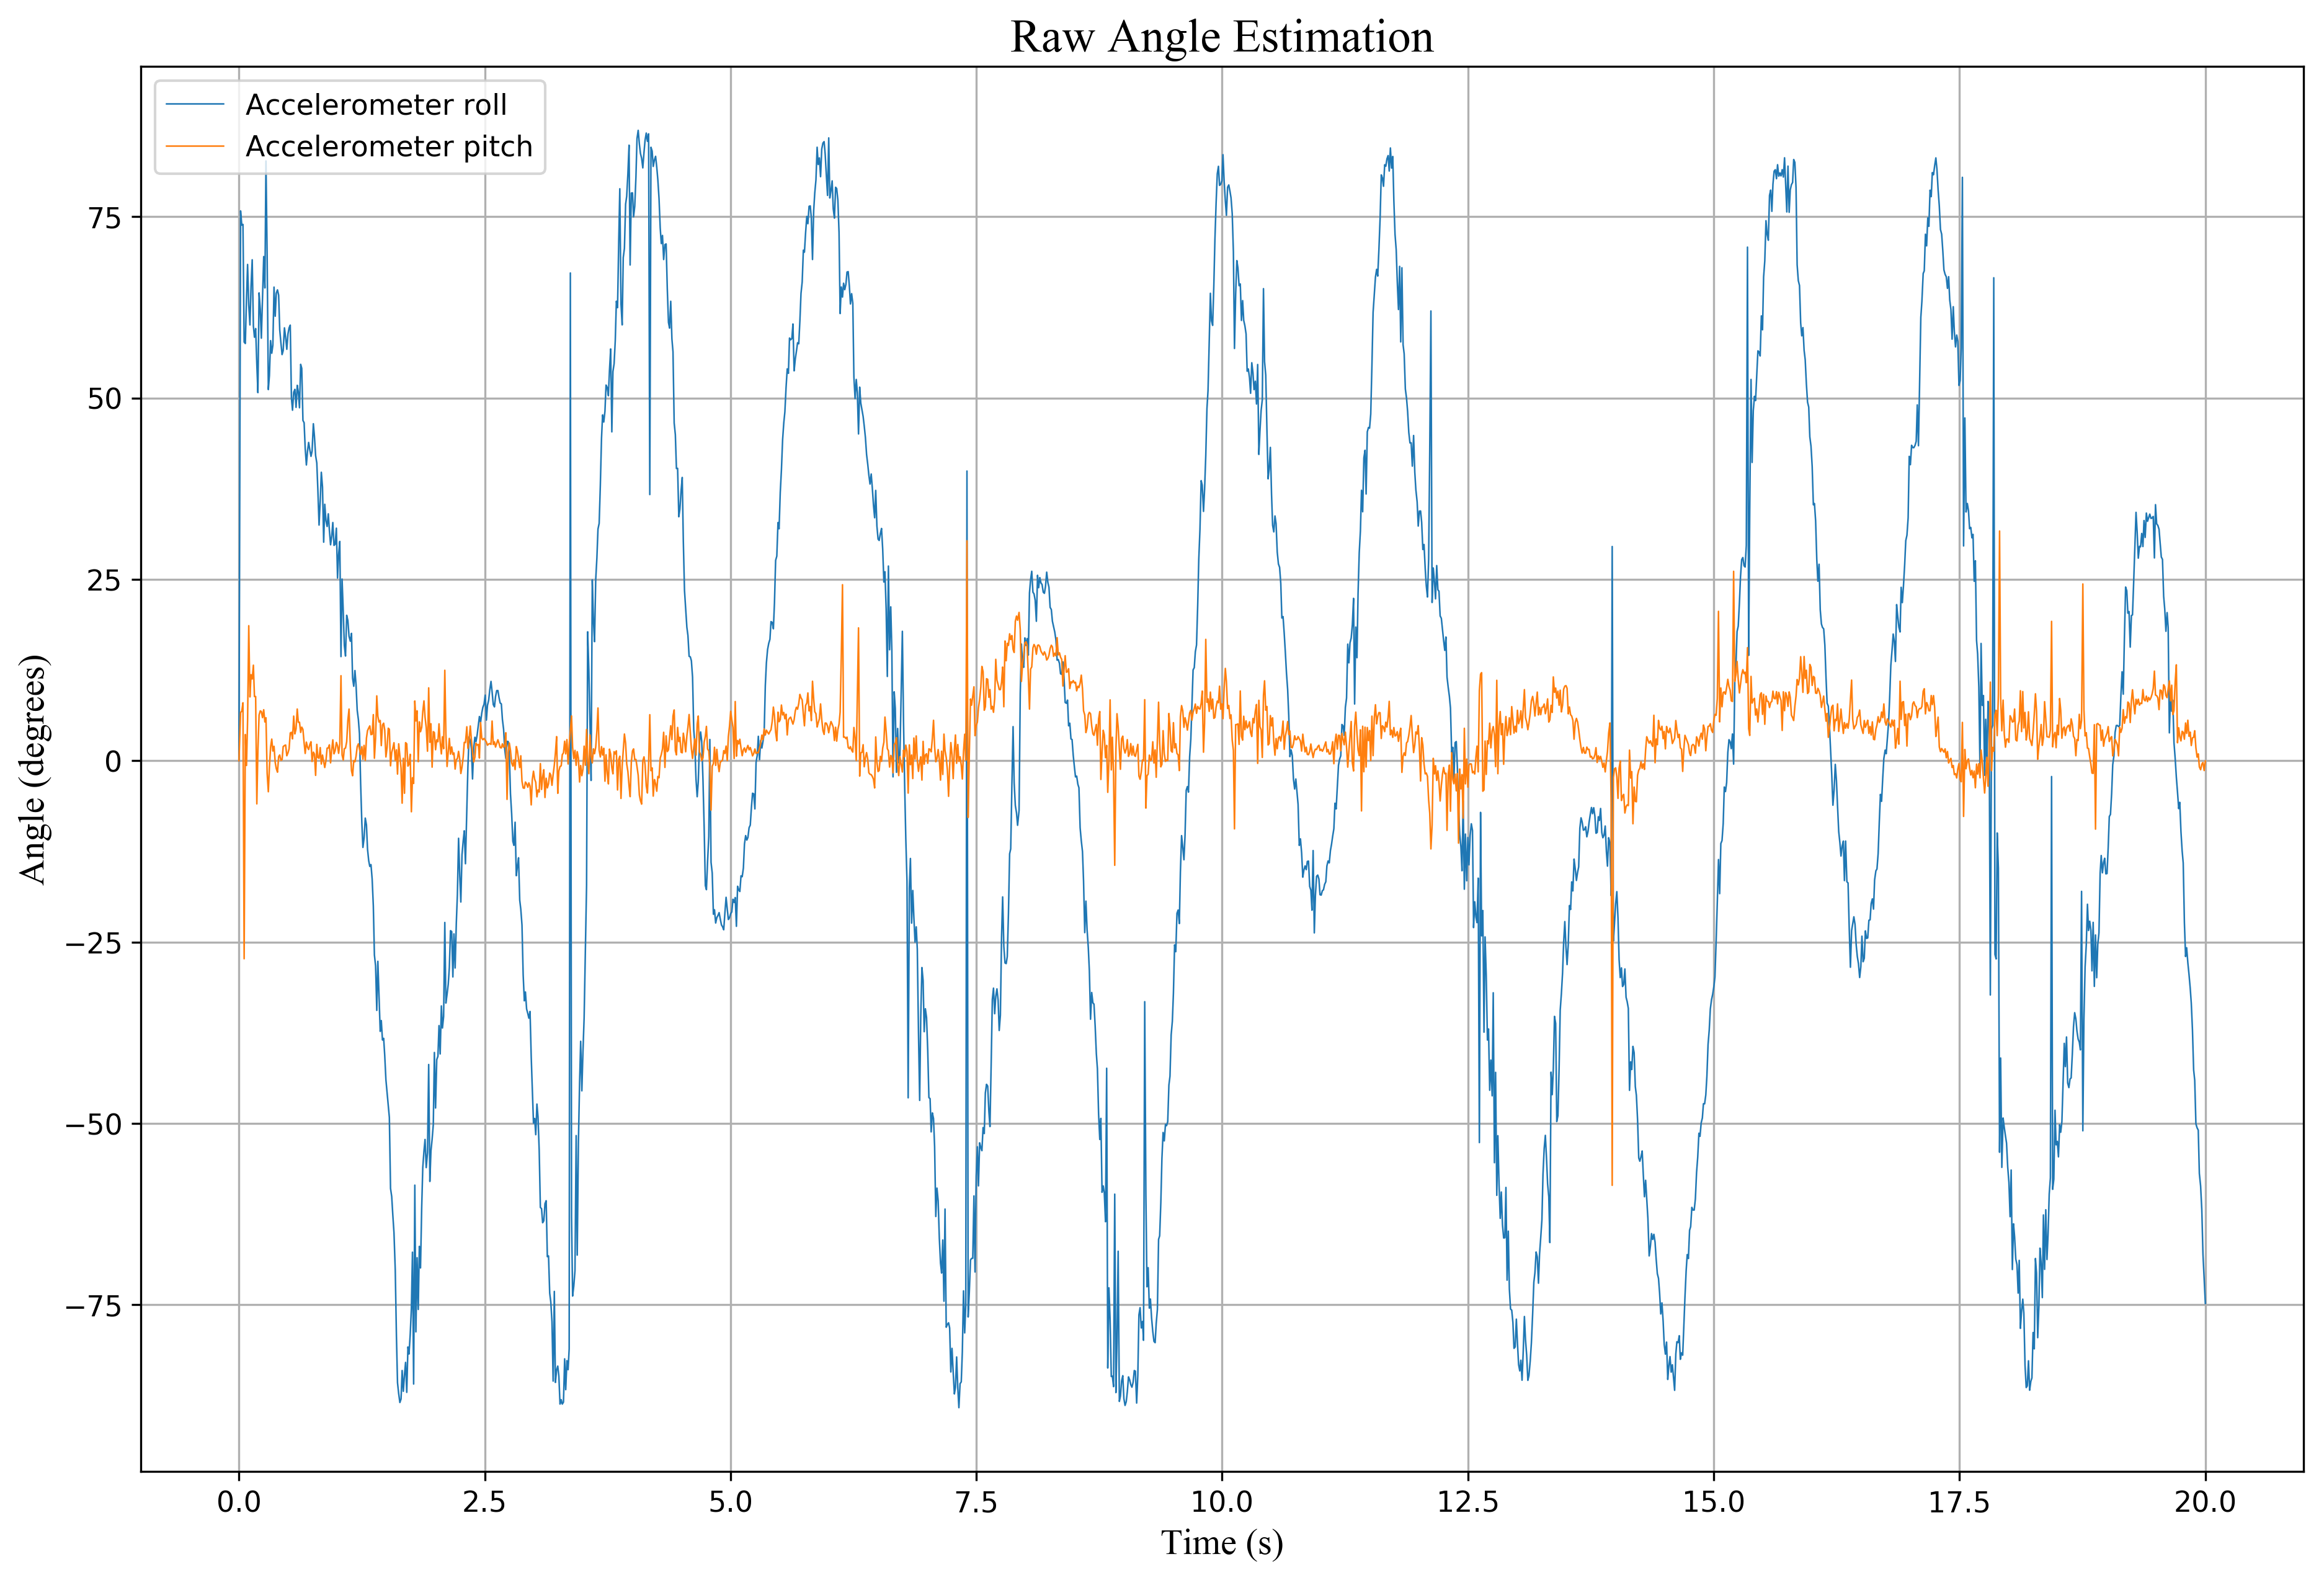

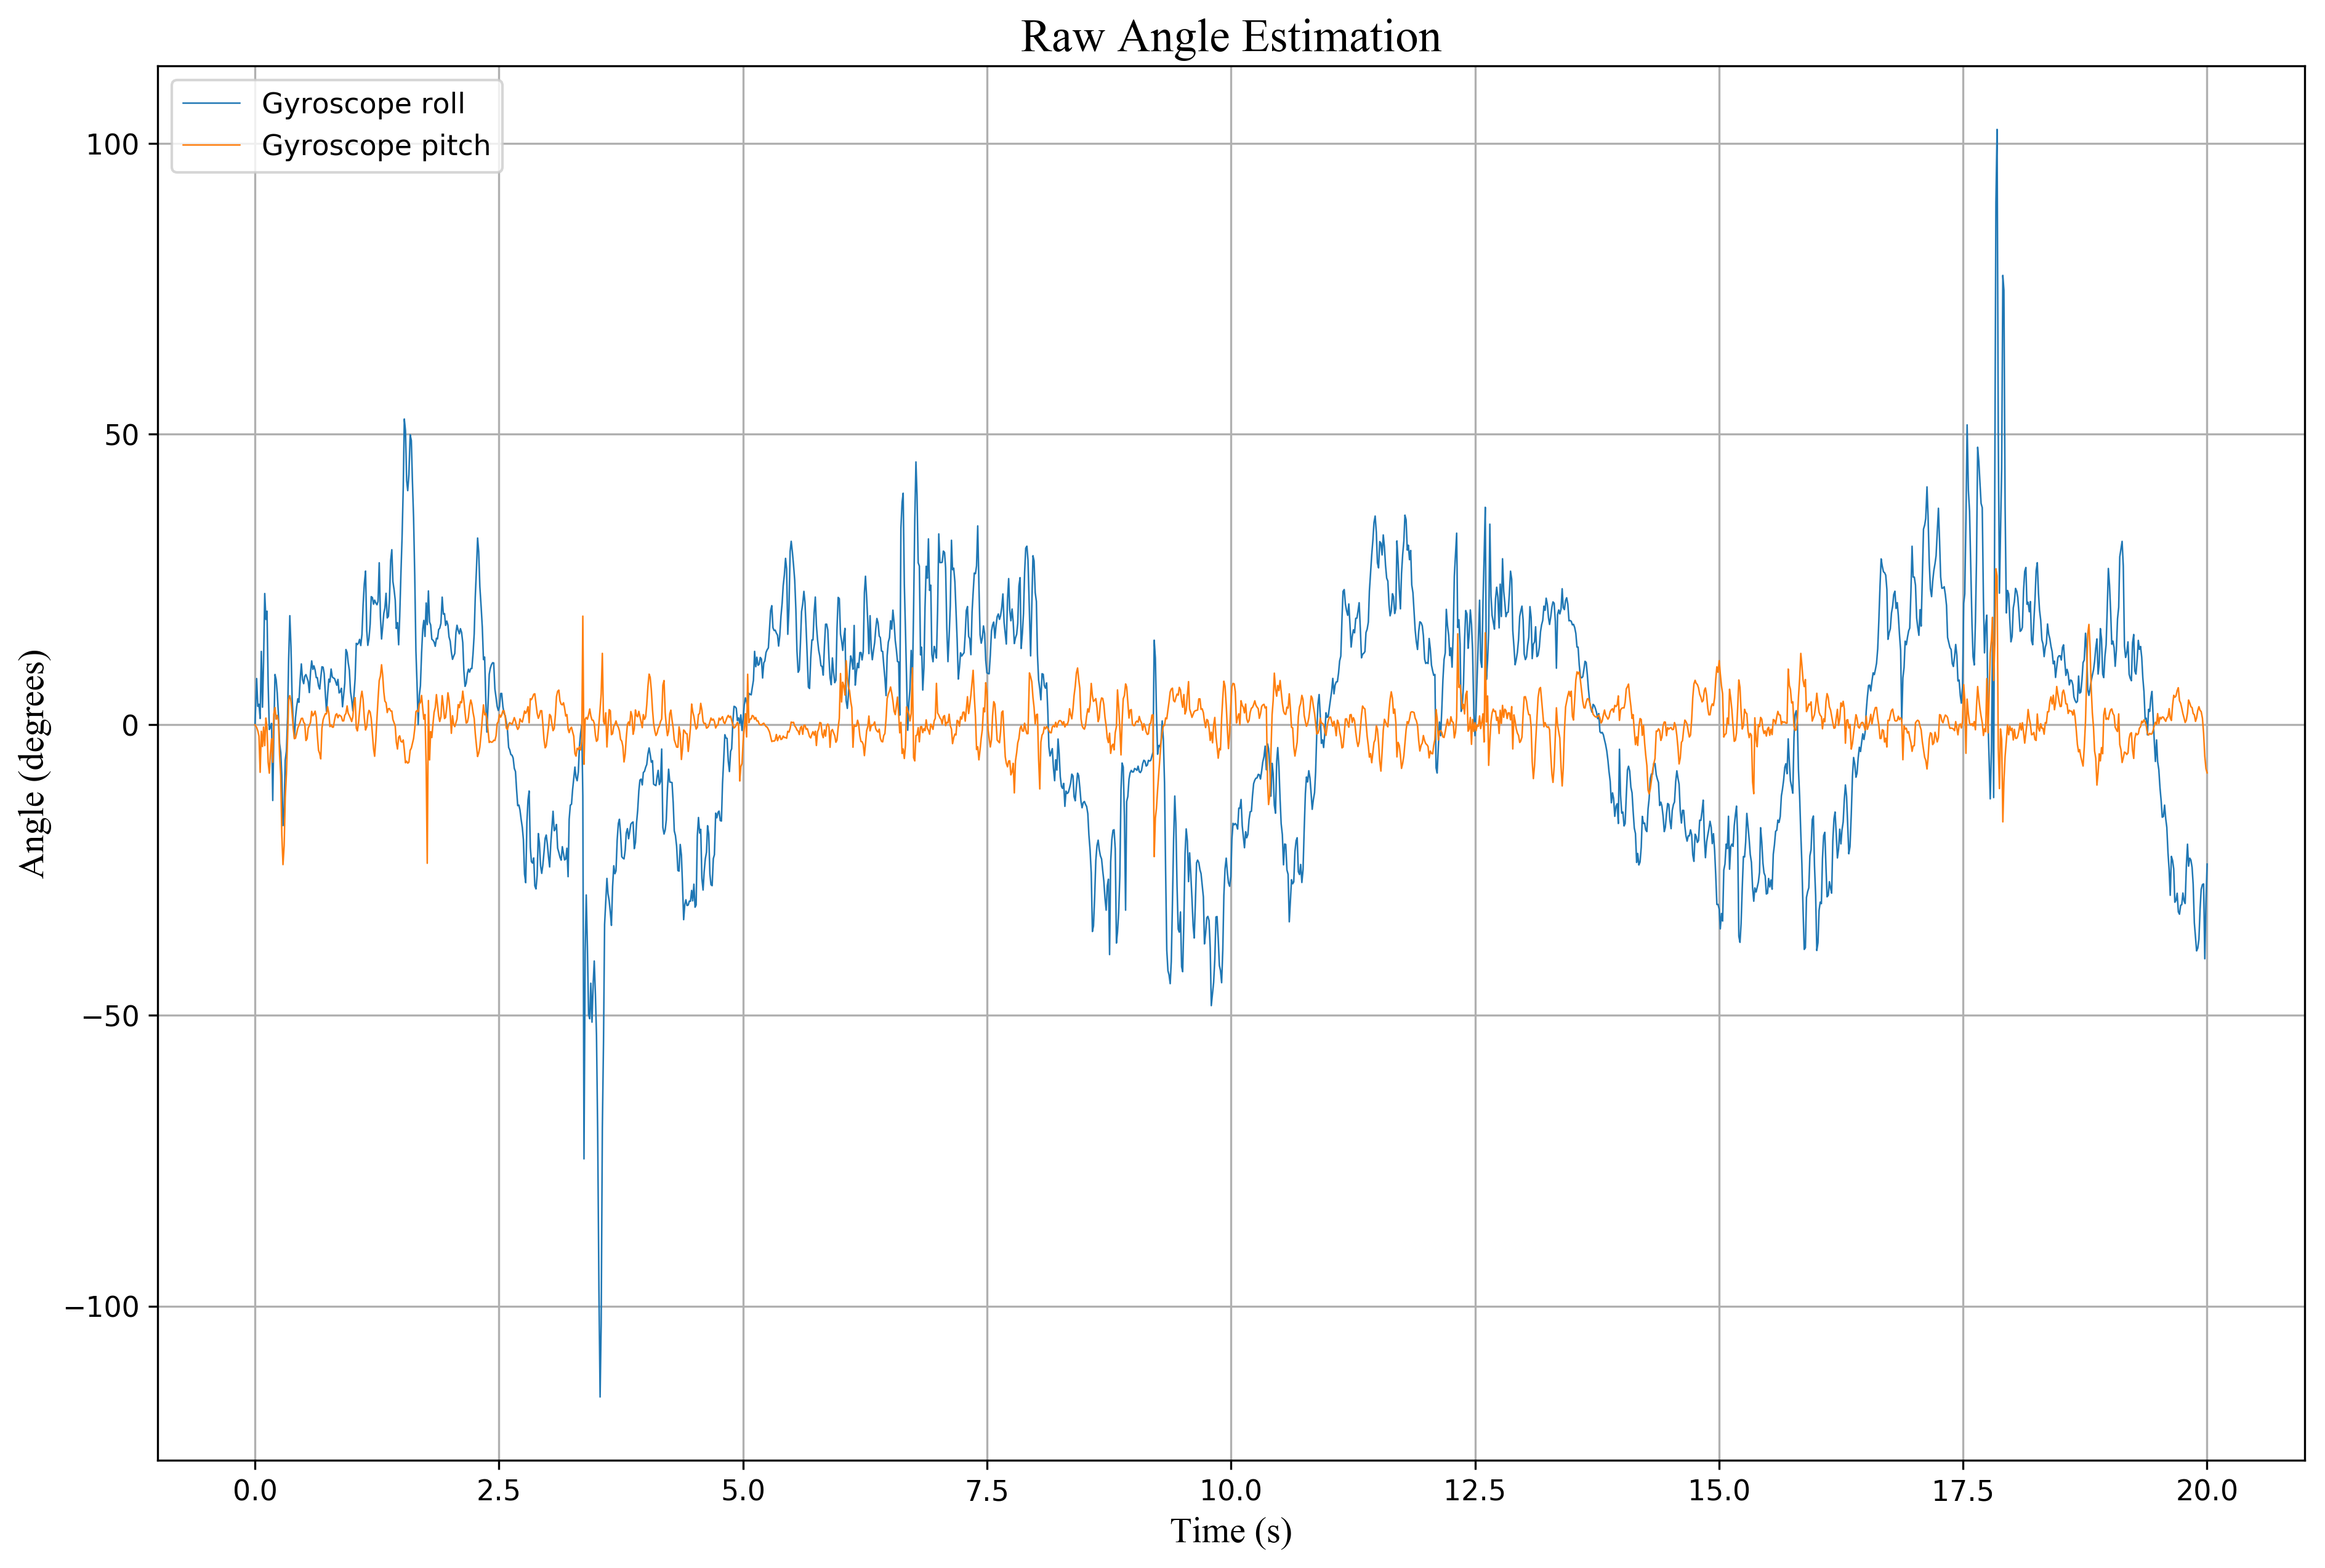

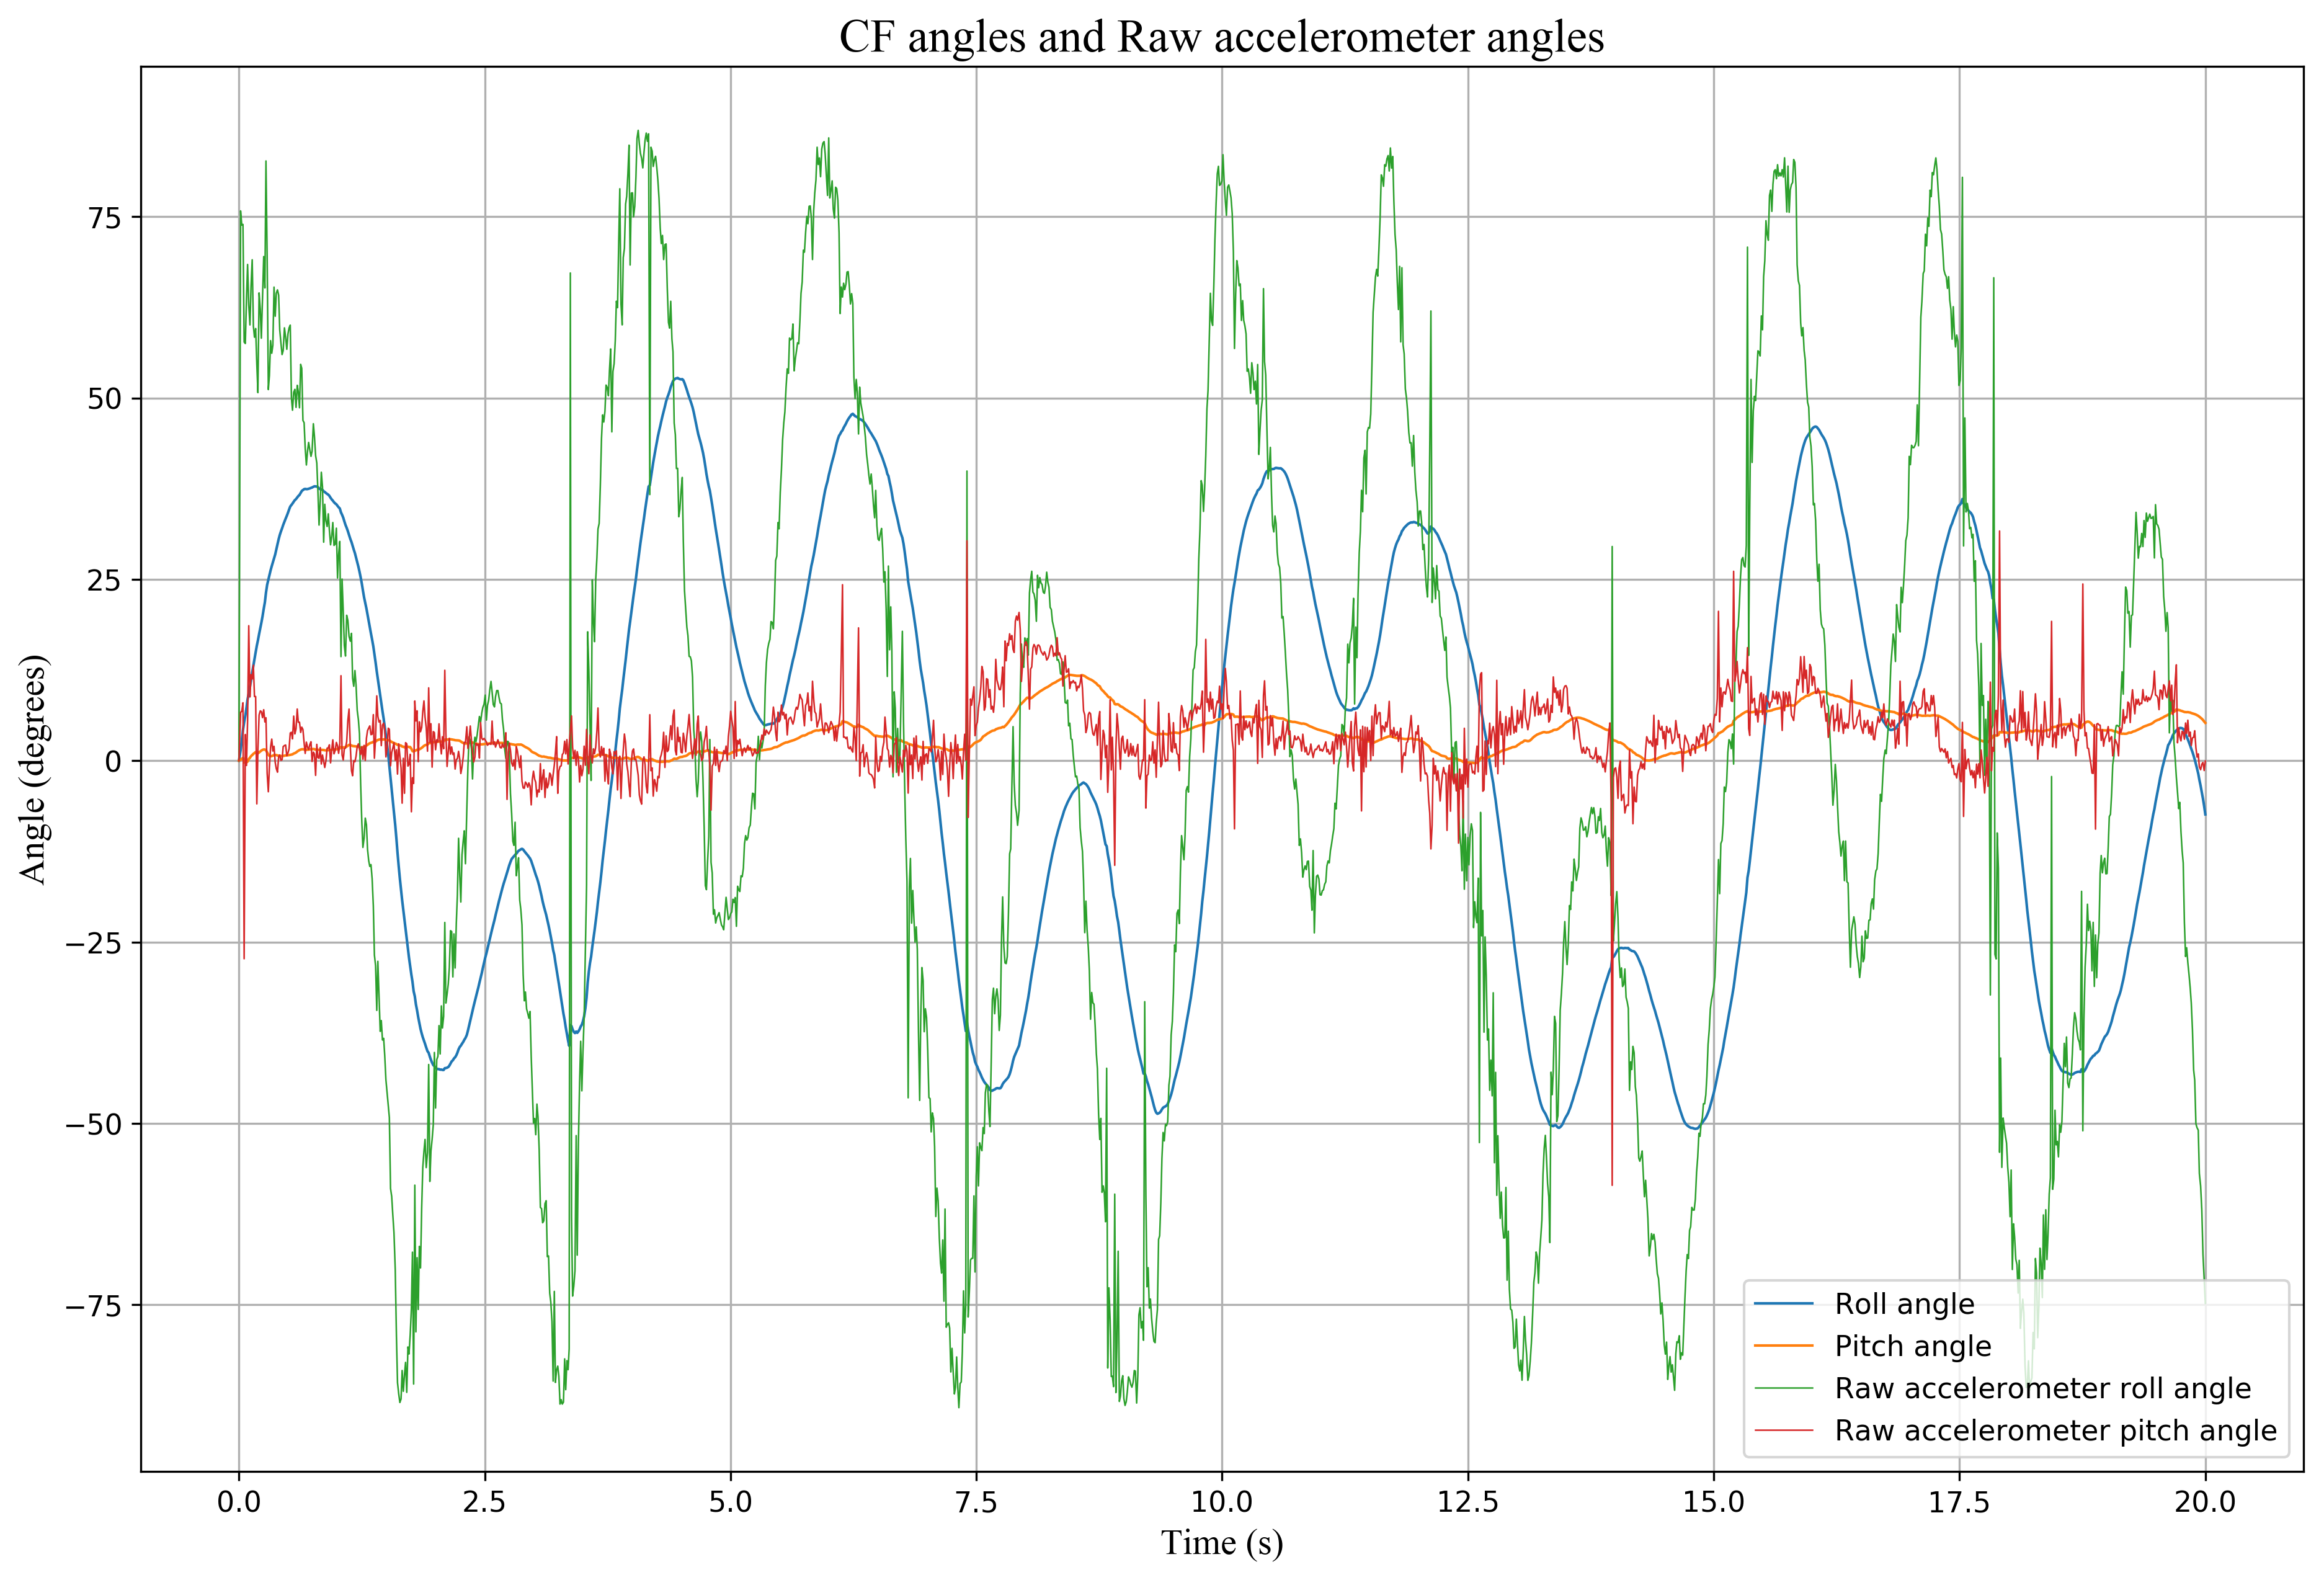

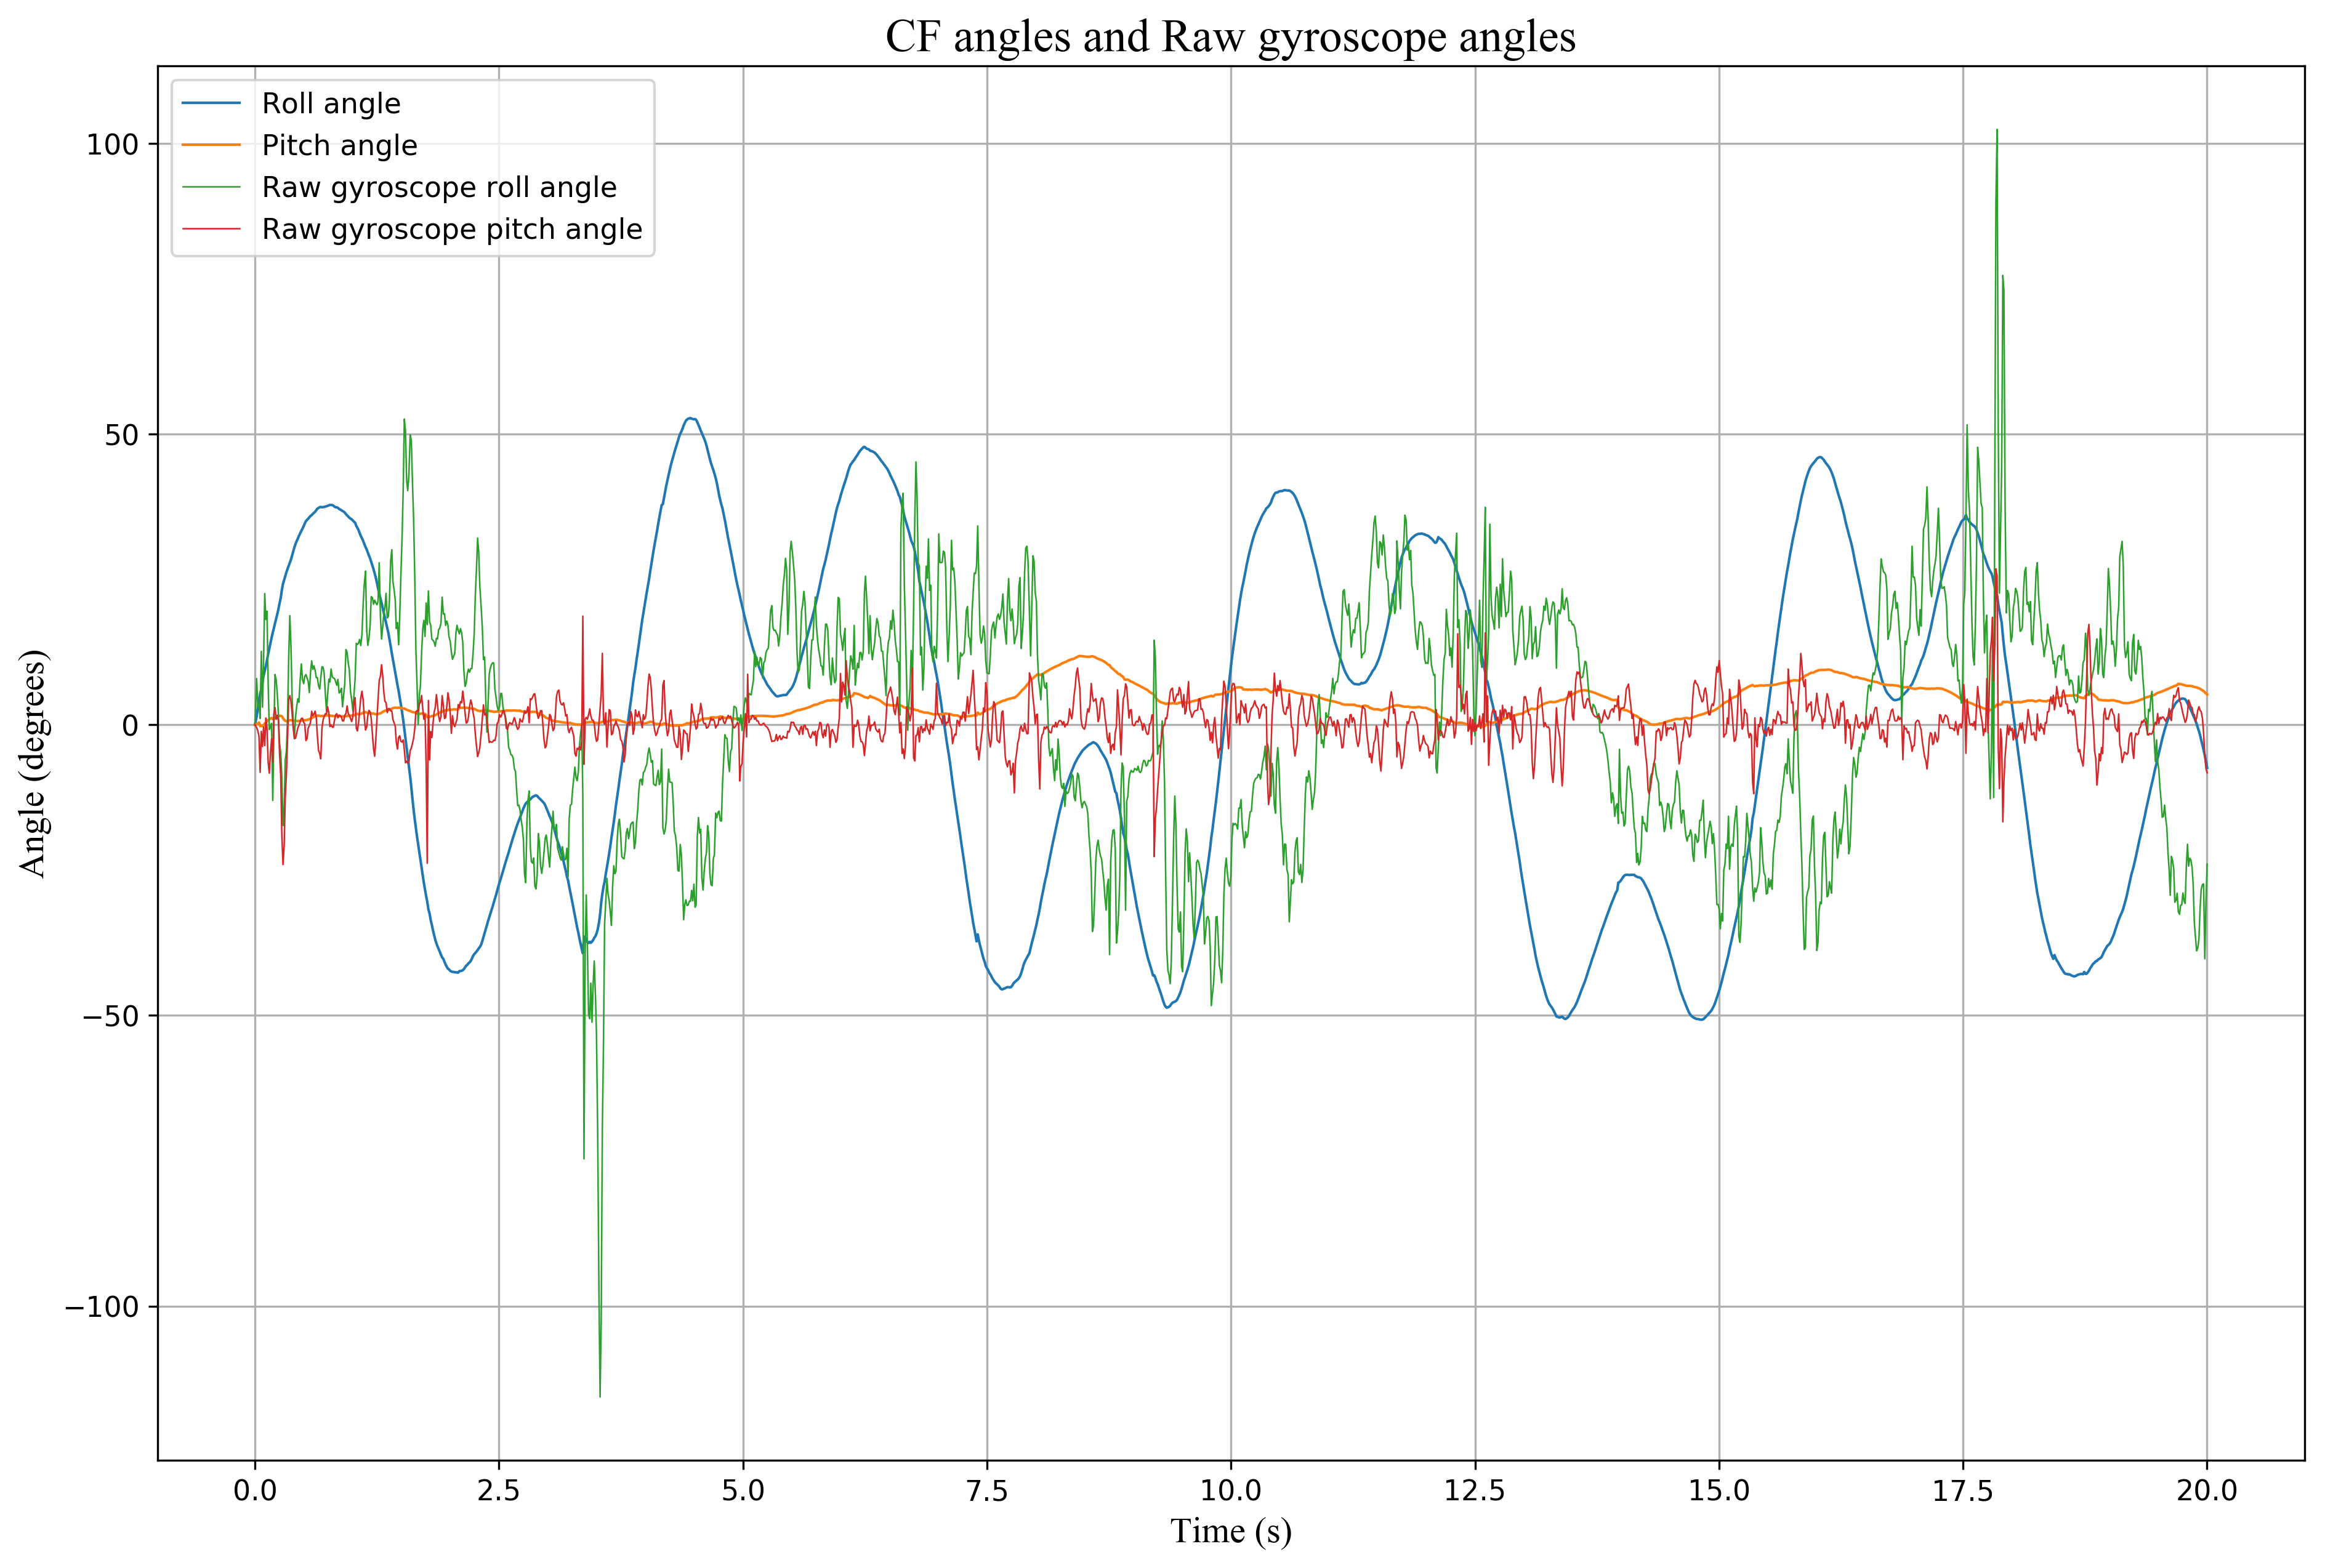

In [45]:
plt.rcParams['figure.dpi'] = 300
# Plot 1 - Gyro Readings 
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 11})
plt.plot(Data[:,0]/1000, Data[:,4], linewidth = 0.6)
plt.plot(Data[:,0]/1000, Data[:,5], linewidth = 0.6)
plt.plot(Data[:,0]/1000, Data[:,6], linewidth = 0.6)
ax = plt.gca()
plt.xlabel('Time (s)', **csfont, fontsize = 14)
plt.ylabel('Angular veolocity (degrees/s)', **csfont, fontsize = 14)
plt.title('Gyroscope readings', **csfont, fontsize = 18)
plt.grid(True)
plt.savefig('RAW_GYRO_READINGS.png')
plt.legend(['Gx', 'Gy', 'Gz'])
plt.show()

#Plot 2 - Accel Readings
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 11})
plt.plot(Data[:,0]/1000, Data[:,1], linewidth = 0.6)
plt.plot(Data[:,0]/1000, Data[:,2], linewidth = 0.6)
plt.plot(Data[:,0]/1000, Data[:,3], linewidth = 0.6)
ax = plt.gca()
plt.xlabel('Time(s)', **csfont, fontsize = 14)
plt.ylabel('Normalized g-force', **csfont, fontsize = 14)
plt.title('Accelerometer readings', **csfont, fontsize = 18)
plt.grid(True)
plt.legend(['Ax', 'Ay', 'Az'])
plt.savefig('RAW_ACCELEROMETER_READINGS.png')
plt.show()

#Plot 3 - Raw angle estimation, Accelerometer
plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size': 11})
plt.plot(Data[:,0]/1000, Data[:,9], linewidth = 0.6)
plt.plot(Data[:,0]/1000, Data[:,10], linewidth = 0.6)
ax = plt.gca()
plt.xlabel('Time (s)', **csfont, fontsize = 14)
plt.ylabel('Angle (degrees)', **csfont, fontsize = 14)
plt.title('Raw Angle Estimation', **csfont, fontsize = 18)
plt.grid(True)
plt.legend(['Accelerometer roll', 'Accelerometer pitch'])
plt.savefig('RAW_ANGLE_ESTIMATION_ACCELEROMETER.png')
plt.show()

#Plot 4 - Raw angle estimation, Gyroscope
plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size': 11})
plt.plot(Data[:,0]/1000, Data[:,11], linewidth = 0.6)
plt.plot(Data[:,0]/1000, Data[:,12], linewidth = 0.6)
ax = plt.gca()
plt.xlabel('Time (s)', **csfont, fontsize = 14)
plt.ylabel('Angle (degrees)', **csfont, fontsize = 14)
plt.title('Raw Angle Estimation', **csfont, fontsize = 18)
plt.grid(True)
plt.legend(['Gyroscope roll', 'Gyroscope pitch'])
plt.savefig('RAW_ANGLE_ESTIMATION_GYROSCOPE.png')
plt.show()

#Plot 5 - Raw angle estimation (Accelerometer) overlapped with CF filter 
plt.figure(figsize= (15,10))
plt.rcParams.update({'font.size': 11})
plt.plot(Data[:,0]/1000, Data[:,7], linewidth = 1.0)
plt.plot(Data[:,0]/1000, Data[:,8], linewidth = 1.0)
plt.plot(Data[:,0]/1000, Data[:,9], linewidth = 0.6)
plt.plot(Data[:,0]/1000, Data[:,10], linewidth = 0.6)
ax = plt.gca()
plt.xlabel('Time (s)', **csfont, fontsize = 14)
plt.ylabel('Angle (degrees)', **csfont, fontsize = 14)
plt.title('CF angles and Raw accelerometer angles', **csfont, fontsize = 18)
plt.grid(True)
plt.legend(['Roll angle', 'Pitch angle', 'Raw accelerometer roll angle', 'Raw accelerometer pitch angle'])
plt.savefig('CF_VS_ACCELEROMETER.png')
plt.show()

#Plot 6 - Raw angle estimation (Gyroscope) overlapped with CF filter 
plt.figure(figsize= (15,10))
plt.rcParams.update({'font.size': 11})
plt.plot(Data[:,0]/1000, Data[:,7], linewidth = 1.0)
plt.plot(Data[:,0]/1000, Data[:,8], linewidth = 1.0)
plt.plot(Data[:,0]/1000, Data[:,11], linewidth = 0.6)
plt.plot(Data[:,0]/1000, Data[:,12], linewidth = 0.6)
ax = plt.gca()
plt.xlabel('Time (s)', **csfont, fontsize = 14)
plt.ylabel('Angle (degrees)', **csfont, fontsize = 14)
plt.title('CF angles and Raw gyroscope angles', **csfont, fontsize = 18)
plt.grid(True)
plt.legend(['Roll angle', 'Pitch angle', 'Raw gyroscope roll angle', 'Raw gyroscope pitch angle'])
plt.savefig('CF_VS_GYROSCOPE.png')
plt.show()

### Pickle time

In [50]:
with open('readings.pickle', 'wb') as handle: 
    pickle.dump(Data, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('readings.pickle', 'rb') as handle:
    importedData = pickle.load(handle)
print(Data == importedData)

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]
